# NB04: Condition-Specific Genes

**Project**: ADP1 Deletion Collection Phenotype Analysis

**Goal**: For each carbon source, identify genes whose growth importance is specific to that condition. Compute a condition specificity score and annotate top genes per condition.

**Input**: `data/growth_matrix_complete.csv`

**Outputs**:
- `data/condition_specific_genes.csv` — all genes with specificity scores
- Annotated top gene lists per condition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'

df = pd.read_csv(os.path.join(DATA_DIR, 'growth_matrix_complete.csv'))

GROWTH_COLS = [
    'mutant_growth_acetate', 'mutant_growth_asparagine',
    'mutant_growth_butanediol', 'mutant_growth_glucarate',
    'mutant_growth_glucose', 'mutant_growth_lactate',
    'mutant_growth_quinate', 'mutant_growth_urea'
]
CONDITION_NAMES = [c.replace('mutant_growth_', '') for c in GROWTH_COLS]

print(f'Loaded {len(df):,} genes')

Loaded 2,034 genes


## 1. Condition Specificity Score

For each gene, compute z-scores across 8 conditions. A gene is condition-specific if it has one extreme z-score value while the rest are near zero.

**Specificity score**: For each condition *i*, score = |z_i| - mean(|z_j|) for j ≠ i. High positive score means this gene is specifically important (or specifically unimportant) for condition *i*.

We also track the **direction**: negative z-score = growth defect (gene is important), positive z-score = growth advantage.

In [2]:
# Z-score per condition
X = df[GROWTH_COLS].values
scaler = StandardScaler()
X_z = scaler.fit_transform(X)

# Compute specificity scores for each gene × condition
specificity = np.zeros_like(X_z)
for i in range(8):
    abs_z = np.abs(X_z)
    other_cols = [j for j in range(8) if j != i]
    mean_other = abs_z[:, other_cols].mean(axis=1)
    specificity[:, i] = abs_z[:, i] - mean_other

# For each gene, find the most specific condition
df['most_specific_condition'] = [CONDITION_NAMES[i] for i in np.argmax(specificity, axis=1)]
df['max_specificity'] = specificity.max(axis=1)
df['most_specific_zscore'] = [X_z[g, np.argmax(specificity[g])] for g in range(len(df))]
df['specificity_direction'] = np.where(df['most_specific_zscore'] < 0, 'defect', 'advantage')

# Add per-condition specificity scores
for i, name in enumerate(CONDITION_NAMES):
    df[f'specificity_{name}'] = specificity[:, i]
    df[f'zscore_{name}'] = X_z[:, i]

print(f'Specificity scores computed for {len(df):,} genes × 8 conditions')
print(f'\nMost specific condition distribution:')
print(df['most_specific_condition'].value_counts().to_string())

Specificity scores computed for 2,034 genes × 8 conditions

Most specific condition distribution:
most_specific_condition
acetate       451
glucarate     322
butanediol    304
lactate       294
asparagine    277
urea          248
glucose        70
quinate        68


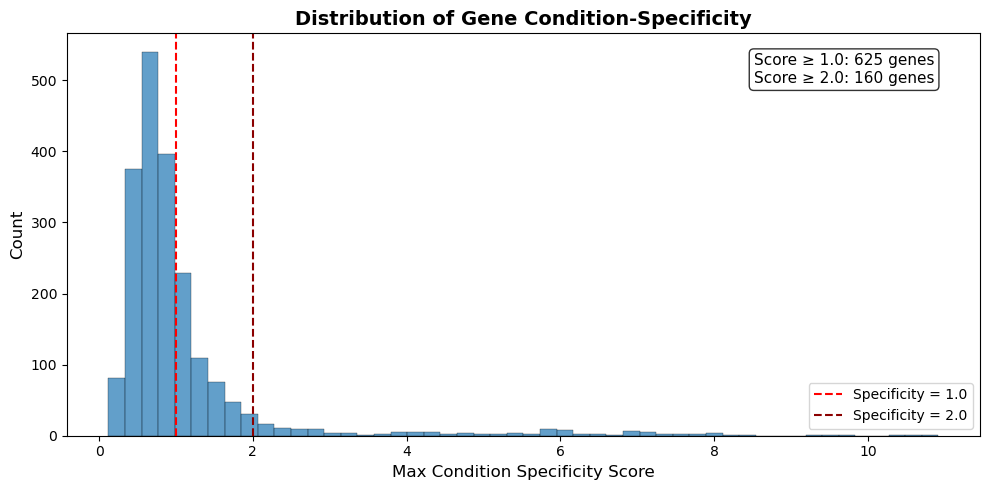

Saved: figures/specificity_distribution.png


In [3]:
# Distribution of specificity scores
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df['max_specificity'], bins=50, edgecolor='black', linewidth=0.3, alpha=0.7)
ax.axvline(1.0, color='red', linestyle='--', label='Specificity = 1.0')
ax.axvline(2.0, color='darkred', linestyle='--', label='Specificity = 2.0')
ax.set_xlabel('Max Condition Specificity Score', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Gene Condition-Specificity', fontsize=14, fontweight='bold')
ax.legend()

n_spec1 = (df['max_specificity'] >= 1.0).sum()
n_spec2 = (df['max_specificity'] >= 2.0).sum()
ax.text(0.95, 0.95, f'Score ≥ 1.0: {n_spec1} genes\nScore ≥ 2.0: {n_spec2} genes',
        transform=ax.transAxes, ha='right', va='top', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'specificity_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/specificity_distribution.png')

## 2. Top Condition-Specific Genes per Carbon Source

In [4]:
# Top 20 condition-specific genes per condition (by defect — negative z-score)
print('=== Top 20 Condition-Specific Genes (growth defect) per Carbon Source ===')

for i, name in enumerate(CONDITION_NAMES):
    col_spec = f'specificity_{name}'
    col_z = f'zscore_{name}'
    
    # Genes with high specificity AND negative z-score (defect)
    candidates = df[df[col_z] < -1.0].nlargest(20, col_spec)
    
    if len(candidates) == 0:
        print(f'\n{name.upper()}: No condition-specific defect genes (z < -1.0)')
        continue
    
    print(f'\n{name.upper()} (n={len(candidates)}):')
    for _, row in candidates.head(10).iterrows():
        func = row['rast_function'][:55] if pd.notna(row['rast_function']) else 'Hypothetical'
        locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
        gene = f" ({row['gene_names']})" if pd.notna(row.get('gene_names')) else ''
        print(f'  {locus:15s}{gene:12s} z={row[col_z]:>6.2f} spec={row[col_spec]:>5.2f}  {func}')

=== Top 20 Condition-Specific Genes (growth defect) per Carbon Source ===

ACETATE (n=20):
  ACIAD3465                   z= -4.85 spec= 4.42  Two-component system sensor histidine kinase
  ACIAD0335       (fadB)      z= -4.80 spec= 4.37  Enoyl-CoA hydratase (EC 4.2.1.17);Delta(3)-cis-delta(2)
  ACIAD3522                   z= -4.80 spec= 4.30  NADH-FMN oxidoreductase
  ACIAD2318                   z= -4.66 spec= 4.03  Bis(5'-nucleosyl)-tetraphosphatase (asymmetrical) (EC 3
  ACIAD1135       (nudC)      z= -4.93 spec= 3.62  NADH pyrophosphatase (EC 3.6.1.22), decaps 5'-NAD modif
  ACIAD3469       (citB)      z= -4.72 spec= 3.46  Two-component transcriptional response regulator, LuxR 
  ACIAD2335                   z= -4.95 spec= 3.04  Malate synthase G (EC 2.3.3.9)
  ACIAD0043                   z= -3.65 spec= 2.84  Similar to phosphoglycolate phosphatase, clustered with
  ACIAD1115       (lon)       z= -3.30 spec= 2.47  ATP-dependent protease La (EC 3.4.21.53) Type I
  ACIAD2284           

## 3. Quinate-Specific Genes — Cross-Reference with Prior Project

The adp1_triple_essentiality project found that aromatic degradation genes drive FBA-growth discordance (OR=9.7). Are these the same genes that are quinate-specific?

In [5]:
# Quinate-specific genes
quinate_specific = df[(df['specificity_quinate'] > 0.5) & (df['zscore_quinate'] < -1.0)]
quinate_specific = quinate_specific.sort_values('specificity_quinate', ascending=False)

print(f'Quinate-specific genes (spec>0.5, z<-1): {len(quinate_specific)}')
print()
print('=== Quinate-Specific Genes ===')
for _, row in quinate_specific.iterrows():
    func = row['rast_function'][:60] if pd.notna(row['rast_function']) else 'Hypothetical'
    locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
    print(f'  {locus:15s} z={row["zscore_quinate"]:>6.2f} spec={row["specificity_quinate"]:>5.2f}  {func}')

# Check if aromatic degradation pathway genes are enriched
aromatic_keywords = ['quinate', 'shikimate', 'protocatechuate', 'benzoate', 'catechol',
                     'aromatic', 'pca', 'pob', 'van', 'hca', 'ben', 'sal']
quinate_aromatic = quinate_specific[quinate_specific['rast_function'].str.lower().str.contains(
    '|'.join(aromatic_keywords), na=False
)]
print(f'\nOf these, aromatic degradation related: {len(quinate_aromatic)}')

Quinate-specific genes (spec>0.5, z<-1): 51

=== Quinate-Specific Genes ===
  ACIAD1710       z= -8.66 spec= 8.02  4-carboxymuconolactone decarboxylase (EC 4.1.1.44)
  ACIAD1712       z= -8.62 spec= 7.99  Protocatechuate 3,4-dioxygenase alpha chain (EC 1.13.11.3)
  ACIAD1716       z= -8.38 spec= 7.94  Quinate/shikimate dehydrogenase [Pyrroloquinoline-quinone] (
  ACIAD1713       z= -8.64 spec= 7.82  3-dehydroquinate dehydratase I (EC 4.2.1.10)
  ACIAD1711       z= -8.47 spec= 7.82  Protocatechuate 3,4-dioxygenase beta chain (EC 1.13.11.3)
  ACIAD1707       z= -8.51 spec= 7.71  3-carboxy-cis,cis-muconate cycloisomerase (EC 5.5.1.2)
  ACIAD2505       z= -8.39 spec= 6.93  Pyrroloquinoline-quinone synthase (EC 1.3.3.11)
  ACIAD2506       z= -8.39 spec= 6.70  Coenzyme PQQ synthesis protein D
  ACIAD1590       z= -7.08 spec= 6.33  Biopolymer transport protein ExbD/TolR
  ACIAD3137       z= -7.06 spec= 6.14  UPF0234 protein Yitk
  ACIAD0739       z= -6.82 spec= 6.10  NADH-ubiquinone oxidoredu

## 4. Urea-Specific Genes — Nitrogen Metabolism

In [6]:
# Urea-specific genes
urea_specific = df[(df['specificity_urea'] > 0.5) & (df['zscore_urea'] < -1.0)]
urea_specific = urea_specific.sort_values('specificity_urea', ascending=False)

print(f'Urea-specific genes (spec>0.5, z<-1): {len(urea_specific)}')
print()
if len(urea_specific) > 0:
    print('=== Top 20 Urea-Specific Genes ===')
    for _, row in urea_specific.head(20).iterrows():
        func = row['rast_function'][:60] if pd.notna(row['rast_function']) else 'Hypothetical'
        locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
        print(f'  {locus:15s} z={row["zscore_urea"]:>6.2f} spec={row["specificity_urea"]:>5.2f}  {func}')
else:
    print('Note: Urea has very low variance — almost all genes show severe defects.')
    print('This makes condition-specificity less meaningful for urea.')
    print(f'Urea std of z-scores: {df["zscore_urea"].std():.3f}')

Urea-specific genes (spec>0.5, z<-1): 138

=== Top 20 Urea-Specific Genes ===
  ACIAD1093       z= -7.87 spec= 7.40  Urease accessory protein UreE
  ACIAD1095       z= -7.76 spec= 7.22  Urease accessory protein UreG
  ACIAD1094       z= -7.65 spec= 7.20  Urease accessory protein UreF
  ACIAD1091       z= -7.55 spec= 7.19  Urease alpha subunit (EC 3.5.1.5)
  ACIAD1090       z= -7.61 spec= 7.12  Urease beta subunit (EC 3.5.1.5)
  ACIAD1089       z= -7.51 spec= 6.96  Urease gamma subunit (EC 3.5.1.5)
  ACIAD1088       z= -7.65 spec= 6.85  Urease accessory protein UreD
  ACIAD0148       z= -5.47 spec= 4.65  DedA protein
  ACIAD1549       z= -4.83 spec= 4.12  Short-chain dehydrogenase, associated with 2-hydroxychromene
  ACIAD0352       z= -5.76 spec= 3.93  Putative pre-16S rRNA nuclease YqgF
  ACIAD0110       z= -6.68 spec= 3.78  K30 capsule biosynthesis cluster, partial sequence
  ACIAD3582       z= -3.38 spec= 3.13  Uncharacterized protein YbbK
  ACIAD1671       z= -3.35 spec= 2.77  hist

## 5. Condition-Specificity Heatmap — Top Genes

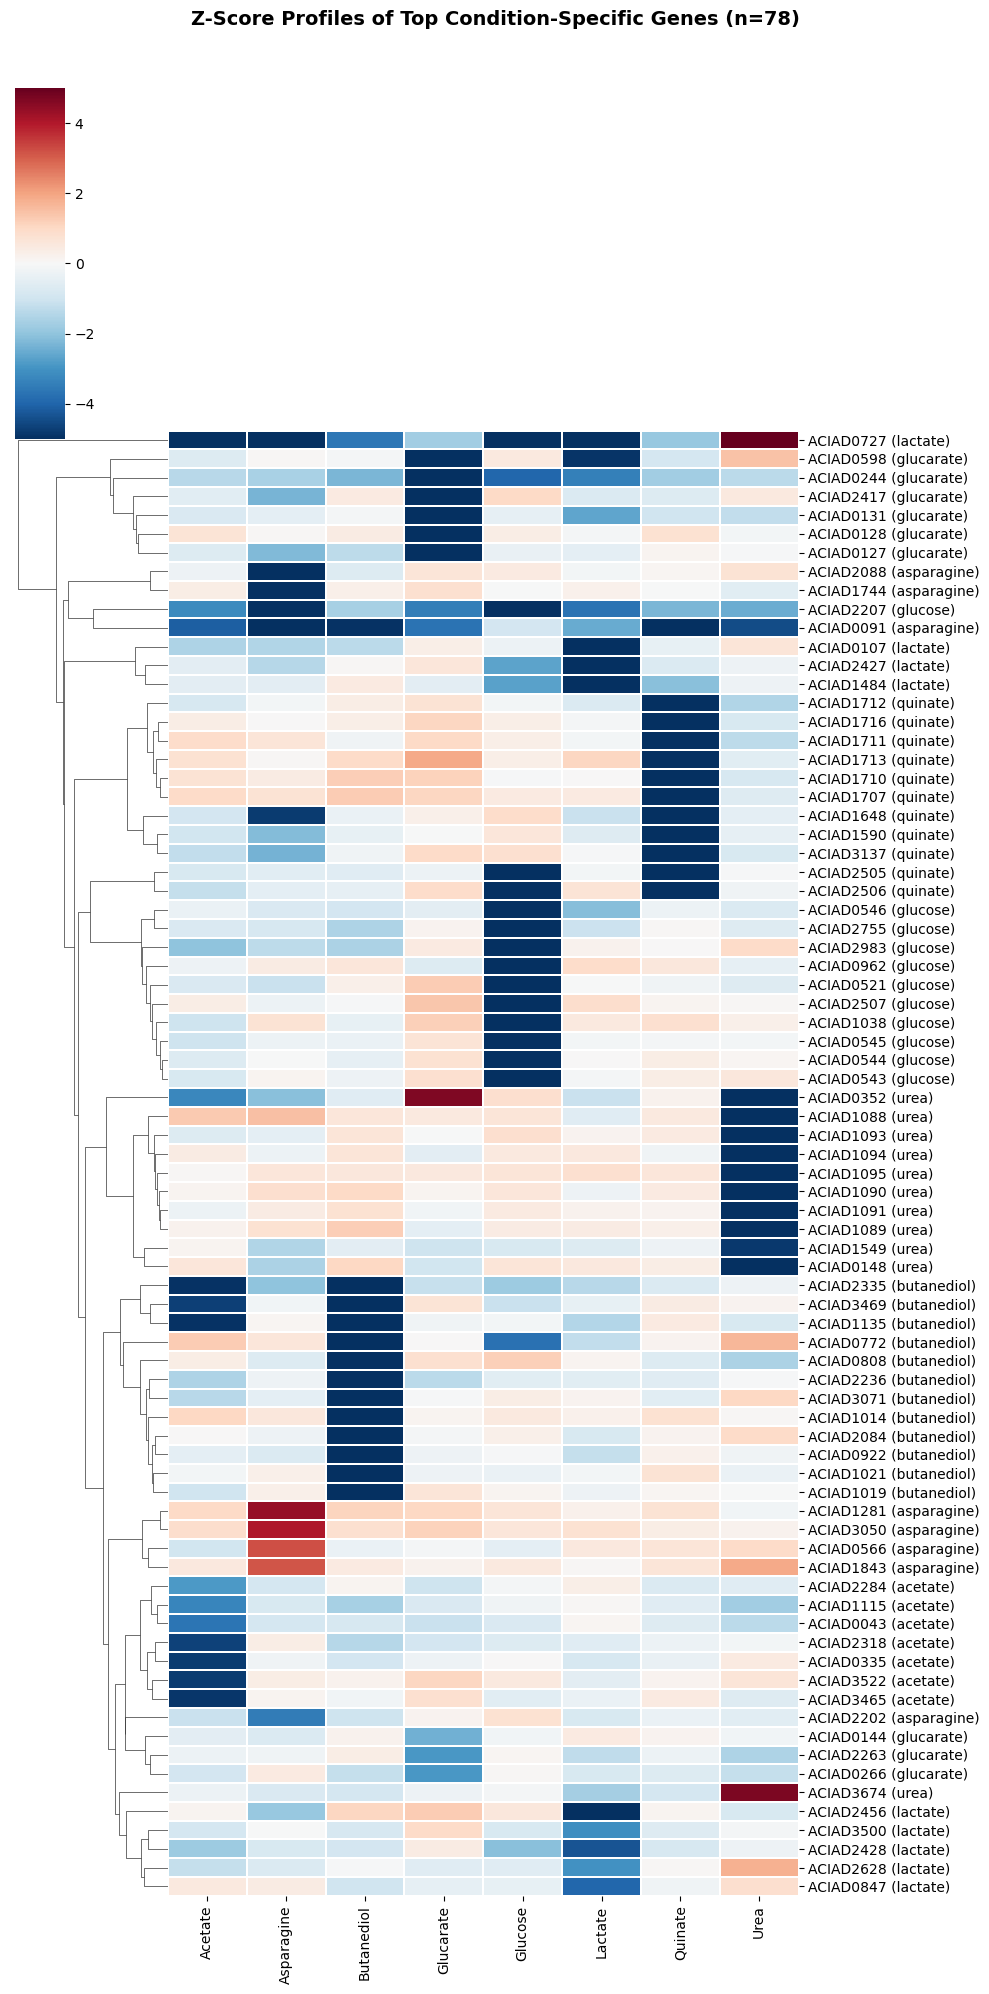

Saved: figures/condition_specific_heatmap.png


In [7]:
# Get top 10 most condition-specific genes per condition
top_genes = []
for name in CONDITION_NAMES:
    col_spec = f'specificity_{name}'
    top = df.nlargest(10, col_spec)
    top_genes.extend(top.index.tolist())

top_genes = list(set(top_genes))  # deduplicate
df_top = df.loc[top_genes]

# Z-score heatmap for these genes
z_cols = [f'zscore_{n}' for n in CONDITION_NAMES]
z_matrix = df_top[z_cols].rename(
    columns={f'zscore_{n}': n.capitalize() for n in CONDITION_NAMES}
)

# Label rows with locus tag or feature_id
row_labels = []
for _, row in df_top.iterrows():
    locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
    cond = row['most_specific_condition']
    row_labels.append(f'{locus} ({cond})')

z_matrix.index = row_labels

g = sns.clustermap(z_matrix, cmap='RdBu_r', center=0, vmin=-5, vmax=5,
                   figsize=(10, max(8, len(top_genes) * 0.25)),
                   row_cluster=True, col_cluster=False,
                   linewidths=0.3, yticklabels=True)
g.fig.suptitle(f'Z-Score Profiles of Top Condition-Specific Genes (n={len(top_genes)})',
               fontsize=14, fontweight='bold', y=1.02)
plt.savefig(os.path.join(FIG_DIR, 'condition_specific_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: figures/condition_specific_heatmap.png')

## 6. Save Results

In [8]:
# Save all genes with specificity scores
df.to_csv(os.path.join(DATA_DIR, 'condition_specific_genes.csv'), index=False)
print(f'Saved: data/condition_specific_genes.csv ({len(df):,} rows)')

print(f'\n=== NB04 Summary ===')
print(f'Genes analyzed: {len(df):,}')
print(f'Genes with specificity ≥ 1.0: {(df["max_specificity"] >= 1.0).sum()}')
print(f'Genes with specificity ≥ 2.0: {(df["max_specificity"] >= 2.0).sum()}')
print(f'\nCondition with most specific genes:')
for name in CONDITION_NAMES:
    n = ((df['most_specific_condition'] == name) & (df['max_specificity'] >= 1.0)).sum()
    if n > 0:
        print(f'  {name:15s} {n:>3} genes')

Saved: data/condition_specific_genes.csv (2,034 rows)

=== NB04 Summary ===
Genes analyzed: 2,034
Genes with specificity ≥ 1.0: 625
Genes with specificity ≥ 2.0: 160

Condition with most specific genes:
  acetate          80 genes
  asparagine      120 genes
  butanediol       72 genes
  glucarate        76 genes
  glucose          48 genes
  lactate          90 genes
  quinate          27 genes
  urea            112 genes
